In [1]:
from functools import reduce, partial
import inspect

from pyquaternion import Quaternion 
from sklearn.metrics import mean_squared_error

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

import warnings
warnings.filterwarnings("ignore")

from Utilities import *

Pixiedust database opened successfully


In [26]:
path1 = 'C:/Users/talaa/PycharmProjects/rl/src/2017_10_26_00_55_52.csv'
dataset = pd.read_csv(path1, skiprows=range(1, 100))
length, width = dataset.shape

## data is collected at 10 Hz

In [27]:
X, y = getInputOutputAccelerationModel(dataset, limit=length, frequency=10.0)

In [28]:
X.head()

,dXB,dYB,dZB,dPsi,dTheta,dPhi,Psi,Theta,moveForward,yawCCW,yawCW,hover
0,0.743953,-0.000005,0.459517,1.250167e-08,0.289567,3.357095e-08,1.643317e-09,-0.294853,1.0,0.0,0.0,0.0
1,1.032476,-0.000007,0.558390,-2.376070e-09,0.250486,3.279071e-08,1.405710e-09,-0.269805,1.0,0.0,0.0,0.0
2,1.313352,-0.000009,0.612646,-3.231714e-08,0.234233,3.758810e-08,-1.826004e-09,-0.246381,1.0,0.0,0.0,0.0
3,1.580046,-0.000010,0.633264,2.209636e-08,0.210405,3.141655e-08,3.836320e-10,-0.225341,1.0,0.0,0.0,0.0
4,1.772718,-0.000011,0.607898,1.038605e-08,0.201931,3.138338e-08,1.422237e-09,-0.205148,1.0,0.0,0.0,0.0


In [29]:
y.head()

,d2XB,d2YB,d2ZB,d2Psi,d2Theta,d2Phi
0,2.742137,-0.000018,1.245581,-1.487774e-07,-0.390810,-7.802389e-09
1,2.661661,-0.000017,0.848481,-2.994107e-07,-0.162530,4.797392e-08
2,2.530217,-0.000016,0.537203,5.441350e-07,-0.238280,-6.171555e-08
3,1.800361,-0.000011,0.103037,-1.171031e-07,-0.084742,-3.316330e-10
4,2.694437,-0.000017,0.310691,-3.552680e-08,-0.160393,1.972977e-08


In [6]:
limit = 8000
integration_error = np.zeros((limit, 6))

## Sanity Check (Acceleration)

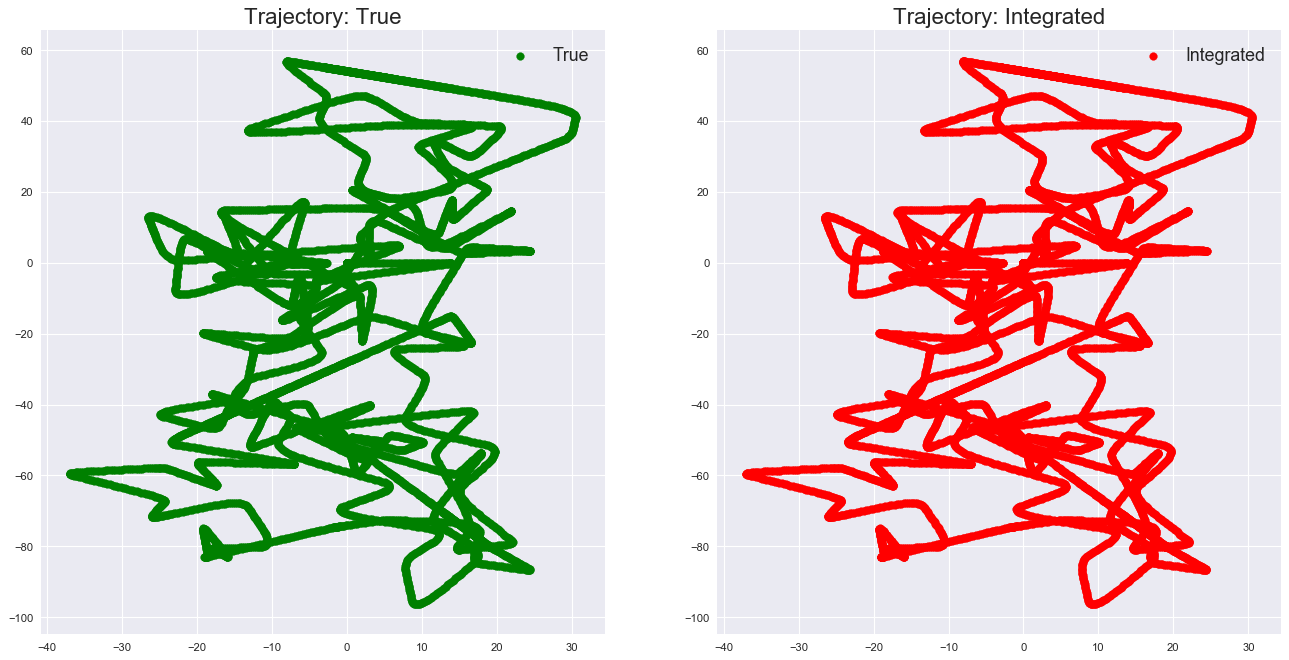

In [7]:
gen2 = integrateTrajectoryAccelerationBody(initialPosition=dataset.loc[1, ['x', 'y', 'z']].values,
                                           initialOrientation=dataset.loc[1, ['psi', 'theta', 'phi']].values,
                                           initialLinearVelocityBody=X.loc[0, ['dXB', 'dYB', 'dZB']].values,
                                           initialAngularVelocity=X.loc[0, ['dPsi', 'dTheta', 'dPhi']].values,
                                           
                                           linearAccelerationsBody=y[['d2XB', 'd2YB', 'd2ZB']].values,
                                           angularAccelerations=y[['d2Psi', 'd2Theta', 'd2Phi']].values,
                                           frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(2, limit):
    p, o = next(gen2)
    
    subplot(1, 2, 1)
    legend(['True'], fontsize=16)
    title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    subplot(1, 2, 2)
    legend(['Integrated'], fontsize=16)
    title('Trajectory: Integrated', fontdict={'fontsize':20})
    plt.scatter(p[0], p[1], color='red')
    
    assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    integration_error[i - 2] = np.concatenate((p.astype(np.float64) - pTrue.astype(np.float64), 
                                               o.astype(np.float64) - oTrue.astype(np.float64)))

In [30]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

# Acceleration Prediction Models

### MLP Regressor (one step)

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(5, ), (10, ), (15, ), (25, )], 'alpha':[1e-4 * np.exp(i) for i in range(10)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['d2Theta'], yTest['d2Theta']) ** 0.5

2.3661048644923972

In [60]:
model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

### Random Forest (one step)

In [50]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=20, random_state=10).fit(xTrain, yTrain)

In [51]:
yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['d2Theta'], yTest['d2Theta']) ** 0.5

1.4153691832360706

In [52]:
def predict(frequency, initial, limit):
    actions = X[['moveForward', 'yawCCW', 'yawCW', 'hover']].values
    initialLinearVelocityBody = X.loc[0, ['dXB', 'dYB', 'dZB']].values
    initialAngularVelocity = X.loc[0, ['dPsi', 'dTheta', 'dPhi']].values
    initialOrientation = initial[['psi', 'theta', 'psi']].values
    
    linear_velocities, angular_velocites = np.ones((limit, 3)), np.ones((limit, 3))
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((initialLinearVelocityBody, initialAngularVelocity, initialOrientation[[0, 1]], actions[i]))
        else:
            s0 = X.iloc[0].values
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        
        initialAngularVelocity = integrateAngularVelocity(initialAngularVelocity, s1[[3, 4, 5]], frequency)
        nextOrientation = integrateOrientation(initialOrientation, initialAngularVelocity, frequency)
        initialLinearVelocityBody = integrateLinearVelocity(initialLinearVelocityBody, s1[[0, 1, 2]], frequency)
        deltaQuaternion = eulerToQuaternion(*nextOrientation) * eulerToQuaternion(*initialOrientation).inverse.unit
        initialLinearVelocityBody = deltaQuaternion.unit.rotate(initialLinearVelocityBody)
        initialOrientation = nextOrientation

        linear_velocities[i-1] = initialLinearVelocityBody
        angular_velocites[i-1] = initialAngularVelocity
    
    return linear_velocities, angular_velocites

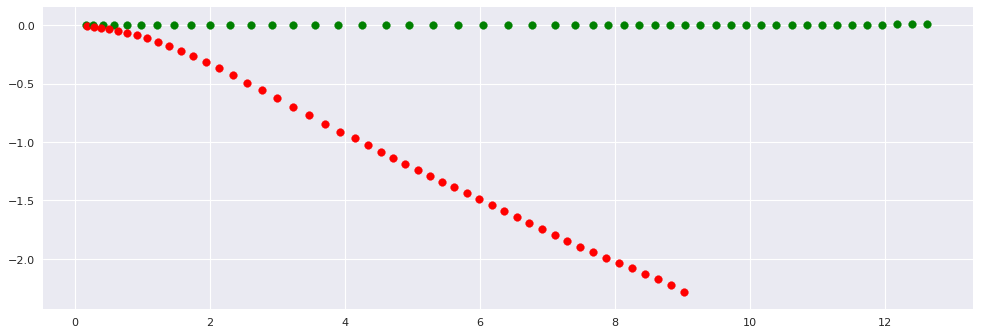

In [77]:
limit = 50
prediction_error = np.zeros((limit, 6))

initial = dataset.iloc[0]
linear_velocities, angular_velocities = predict(10.0, initial, limit)

gen2 = integrateTrajectoryVelocityBody(initialPosition=initial[['x', 'y', 'z']].values,
                                       initialOrientation=initial[['psi', 'theta', 'phi']].values,
                                       linearVelocitiesBody=linear_velocities,
                                       angularVelocities=angular_velocities,
                                       frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, limit):
    p, o = next(gen2)

    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')

    plt.scatter(p[0], p[1], color='red')
    
    prediction_error[i-1] = np.concatenate((p-pTrue, np.rad2deg(getAverageAngularVelocity(oTrue, o, 1.0))))


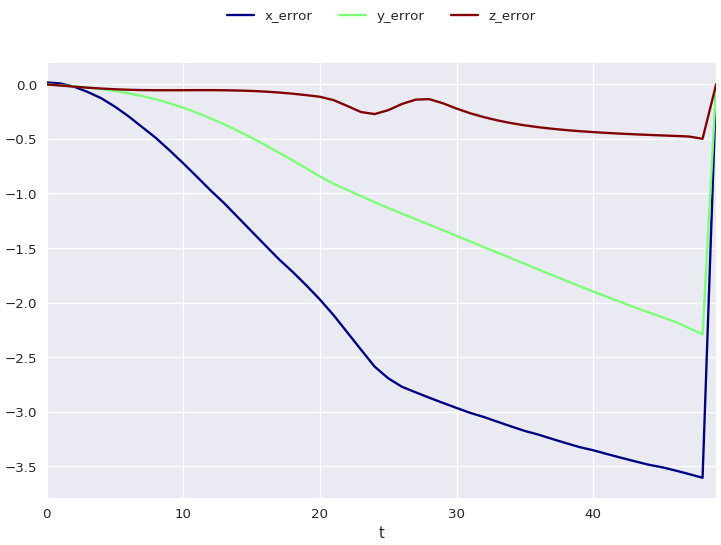

In [78]:
prediction_error_df = pd.DataFrame(prediction_error, columns=['x_error', 'y_error', 'z_error',
                                                              'psi_error', 'theta_error', 'phi_error'])
prediction_error_df['t'] = prediction_error_df.index
display(prediction_error_df)


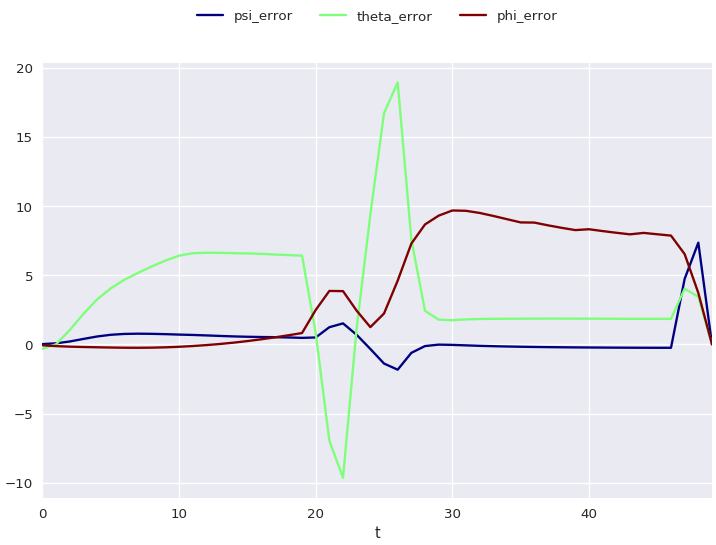

In [79]:
display(prediction_error_df)

### Least-square regression on free parameters (6-d, gravity vector) (one step)

In [13]:
def d2Psi(x, cpsi, c1, d1):
    # Cφ * dPsi + C1 * (moveForward + -hover) + D1
    pass

def d2Theta(x, ctheta, c2, c3, d2):
    # Ċθ * dTheta + C2 * (moveForward + -hover) + D2
    return ctheta * x['dTheta'] + c2 * x['moveForward'] + c3 * x['hover'] + d2

def d2Phi(x, cphi, c4, d3):
    # Cω * dPhi + C3 * (-yawCw + yawCCw) + D3
    return cphi * x['dPhi'] + c4 * (-x['yawCW'] + x['yawCCW']) + d3

def d2XB(x):
    # Cx * dXB + gx
    pass

def d2YB(x):
    # Cy * dYB + gy + D0
    pass

def d2ZB(x):
    # Cz * dZB + gz + C4 * u4 + D4
    pass

In [57]:
from scipy.optimize import curve_fit

d2Theta_fitted = partial(d2Theta, **dict(zip(inspect.getargspec(d2Theta).args[1:], curve_fit(d2Theta, X, y['d2Theta'])[0])))
d2Phi_fitted = partial(d2Phi, **dict(zip(inspect.getargspec(d2Phi).args[1:], curve_fit(d2Phi, X, y['d2Phi'])[0])))

In [58]:
mean_squared_error(d2Theta_fitted(x=X).values, y['d2Theta'].values) ** 0.5

6.473950355407716